# Karyn's Running Racing Analysis

The inital concept of this notebook was to be used as a tool for predicting average pace ahead of races. Then, I went and broke my hip in my final marathon. I picked this project up after that event and decided to flip it into a retrospective. I got my Garmin Venu watch Christmas of 2021 and had running data from that point to September of 2025, from training runs to races: a total of 544 data points. Not a lot for a "true" analysis, but clearly a lot to run given the state of my body.

Note injuries from December 2022 - April 2023, March - May 2024, and July 2024 - November 2024. This automatically offers some explaintion for performance peaks and troughs, despite cross training.

Steps taken in this notebook:
- Prepare and transform Garmin running data
- Create normalized performance metrics
- Compare training and race performance
- Visualize longitudinal trends
- Explore physiological and recovery correlates of performance

In [1]:
import numpy as np
import pandas as pd
import sklearn
from math import *
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from datetime import datetime, date

from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.arima_model import ARIMA

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# This sets some nicer defaults for plotting.
# This must be run in a separate cell from importing matplotlib due to a bug.
params = {'legend.fontsize': 'large',
          'figure.figsize': (11.0, 11.0),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'}
mpl.rcParams.update(params)

# This makes it so that the pandas dataframes don't get truncated horizontally.
pd.options.display.max_columns = 200

## Load and Look at the Data

In [3]:
df_running = pd.read_csv("running_activities.csv")

Oldest recorded runs, beginning December 2021:

In [4]:
df_running.head()

,Activity_Type,Date,Title,Race,Distance,Calories,Time,Avg_HR,Max_HR,Avg_Run_Cadence,Max_Run_Cadence,Avg_Pace,Best_Pace,Total_Ascent,Total_Descent,Avg_Stride_Length,Best_Lap_Time,Moving_Time,Min_Elevation,Max_Elevation,7_More_Hours_Sleep
0,Running,12/27/21 11:04,Henrico County Running,No,4.04,373,00:35:38,160,173,153,249,08:49,07:28,20,--,1.2,00:25.7,00:35:31,217,244,Yes
1,Treadmill Running,12/28/21 14:07,Treadmill Running,No,3.65,318,00:30:37,150,168,146,157,08:23,08:44,--,--,1.12,00:54.8,00:29:37,--,--,Yes
2,Treadmill Running,12/28/21 14:41,Treadmill Running,No,3.63,364,00:31:48,163,171,142,159,08:45,06:55,--,--,1.29,05:31.4,00:29:55,--,--,Yes
3,Running,12/30/21 16:10,Henrico County Running,No,3.21,322,00:29:04,159,174,147,227,09:03,07:20,7,7,1.21,01:46.8,00:28:58,219,233,Yes
4,Treadmill Running,12/30/21 19:20,Treadmill Running,No,1.18,105,00:10:01,150,165,148,157,08:29,07:42,--,--,1.29,01:29.2,00:10:01,--,--,Yes


Most recent recorded runs; last run being 28 September, 2025:

In [5]:
df_running.tail()

,Activity_Type,Date,Title,Race,Distance,Calories,Time,Avg_HR,Max_HR,Avg_Run_Cadence,Max_Run_Cadence,Avg_Pace,Best_Pace,Total_Ascent,Total_Descent,Avg_Stride_Length,Best_Lap_Time,Moving_Time,Min_Elevation,Max_Elevation,7_More_Hours_Sleep
539,Treadmill Running,9/14/25 14:49,Treadmill Running,No,1.01,77,08:43.4,139,158,135,164,08:41,06:45,--,--,1.37,00:01.8,08:09.8,--,--,Yes
540,Running,9/22/25 19:40,Odense Running,No,3.32,305,00:27:50,163,173,154,168,08:23,07:29,59,49,1.24,02:51.7,00:26:52,41,83,Yes
541,Running,9/23/25 15:57,Odense Running,No,0.11,9,01:14.2,123,142,137,225,11:14,01:52,7,--,1.04,01:14.2,00:01:14,40,55,Yes
542,Running,9/24/25 16:15,Odense Running,No,6.20,527,00:51:49,156,176,155,171,08:21,07:26,112,82,1.24,01:40.4,00:50:07,28,84,No
543,Running,9/28/25 10:06,Odense Running,Yes,26.72,"2,152",04:24:46,153,171,148,238,09:55,06:56,371,377,1.09,05:48.1,04:22:54,3,78,Yes


In [6]:
def summarize_dataframe(df):
    """Summarize a dataframe, and report missing values."""
    missing_values = pd.DataFrame({'Variable Name': df.columns,
                                   'Data Type': df.dtypes,
                                   'Missing Values': df.isnull().sum(),
                                   'Unique Values': [df[name].nunique() for name in df.columns]}
                                 ).set_index('Variable Name')
    with pd.option_context("display.max_rows", 1000):
        display(pd.concat([missing_values, df.describe(include='all').transpose()], axis=1).fillna(""))

In [7]:
summarize_dataframe(df_running)

,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Activity_Type,object,0,2,544.0,2,Running,322,,,,,,,
Date,object,0,544,544.0,544,12/27/21 11:04,1,,,,,,,
Title,object,0,74,544.0,74,Treadmill Running,217,,,,,,,
Race,object,0,2,544.0,2,No,504,,,,,,,
Distance,float64,0,284,544.0,,,,5.283474,3.799565,0.1,3.14,4.2,6.3525,26.79
Calories,object,0,392,544.0,392,486,4,,,,,,,
Time,object,0,511,544.0,511,00:10:01,4,,,,,,,
Avg_HR,int64,0,63,544.0,,,,151.606618,12.906079,62.0,146.0,153.0,159.0,183.0
Max_HR,int64,0,65,544.0,,,,169.433824,13.575084,68.0,163.0,170.5,177.0,198.0
Avg_Run_Cadence,object,0,57,544.0,57,146,37,,,,,,,


Data quirks to keep in mind going forward:
 - Activity type "Running" can mean a road or trail run; the only other type is "Treadmill"
 - Training intent is unobserved
 - Course and terrain are not accounted for
 - Sleep is only cataloged as Yes/No; I did not specify how much was had since it's the Garmin tracker isn't the most reliable...

In [8]:
# Parse date
df_running["Date"] = pd.to_datetime(df_running["Date"])

In [9]:
# Replace Garmin missing markers
df_running = df_running.replace("--", np.nan)

In [10]:
# Convert Race to binary
df_running["is_race"] = (df_running["Race"] == "Yes").astype(int)

In [11]:
# Sleep binary
df_running["good_sleep"] = (df_running["7_More_Hours_Sleep"] == "Yes").astype(int)

In [12]:
# Save a copy of the "fixed" csv - optional

df_running.to_csv("running_predictions_cleaned.csv", index=True)

## Some Engineering and Necessary Adjustments

Because I no longer run and do not have a future race to predict, this notebook focuses on retrospective performance analysis rather than forecasting. ‘Performance’ is operationalized primarily as pace- or speed-based efficiency metrics, evaluated differently for training runs versus races.

Performance metrics that will be used throughout the forthcoming analysis:

- Speed (mph)→ intuitive, distance-normalized
- Pace (sec/mile)→ runner-standard but noisier
- Heart-Rate (HR)-adjusted pace→ proxy for physiological efficiency
- Performance residuals→ deviation from baseline over time

#### Time Conversions

First, I need to convert Time, Avg_Pace, and Best_Pace from strings to seconds.

In [13]:
df_running["Best_Pace"].dropna().unique()[:20]

array(['07:28', '08:44', '06:55', '07:20', '07:42', '07:13', '07:44',
       '07:49', '07:21', '07:10', '07:05', '07:19', '07:26', '07:14',
       '07:56', '05:22', '07:53', '07:37', '05:14', '07:01'], dtype=object)

In [14]:
# Convert the time format (MM:SS per mile) to seconds per mile, where lower = faster
def pace_to_seconds(p):
    if pd.isna(p):
        return np.nan
    
    parts = str(p).split(":")
    
    # Take the last two parts as minutes and seconds
    try:
        m = int(parts[-2])
        s = int(parts[-1][:2])  # handles '45/km'
        return m * 60 + s
    except ValueError:
        return np.nan

In [15]:
df_running["avg_pace_sec"] = df_running["Avg_Pace"].apply(pace_to_seconds)
df_running["best_pace_sec"] = df_running["Best_Pace"].apply(pace_to_seconds)

In [16]:
# Checking it worked and we now have a column in seconds
df_running[["Avg_Pace", "avg_pace_sec"]].head(10)
df_running[["Best_Pace", "best_pace_sec"]].head(10)

,Best_Pace,best_pace_sec
0,07:28,448.0
1,08:44,524.0
2,06:55,415.0
3,07:20,440.0
4,07:42,462.0
5,07:13,433.0
6,07:44,464.0
7,07:49,469.0
8,07:21,441.0
9,07:20,440.0


In [17]:
# Distance-aware pace normalization

df_running["pace_per_mile"] = df_running["avg_pace_sec"]
df_running["log_distance"] = np.log(df_running["Distance"])

I'll add some physiological efficiency features, measuring time against distance. This captures fitness without VO₂ max data (unreliable on my Garmin).

Lower pace_hr_ratio = faster pace at same HR

In [18]:
def moving_time_to_hours(t):
    if pd.isna(t):
        return np.nan
    
    # Remove fractional seconds if present
    t = str(t).split(".")[0]
    parts = t.split(":")
    
    try:
        parts = [int(p) for p in parts]
    except ValueError:
        return np.nan
    
    if len(parts) == 3:      # HH:MM:SS
        h, m, s = parts
    elif len(parts) == 2:    # MM:SS
        h = 0
        m, s = parts
    else:
        return np.nan
    
    return h + m / 60 + s / 3600


In [19]:
df_running["time_hours"] = df_running["Moving_Time"].apply(moving_time_to_hours)

In [20]:
df_running["time_hours"].describe()

count    544.000000
mean       0.753835
std        0.585144
min        0.000000
25%        0.433264
50%        0.640833
75%        0.895486
max        4.879167
Name: time_hours, dtype: float64

In [21]:
# Compute speed
df_running["speed_mph"] = df_running["Distance"] / df_running["time_hours"]

In [22]:
df_running.loc[df_running["time_hours"] <= 0, "speed_mph"] = np.nan

Text(0.5, 1.0, 'Speed vs Distance')

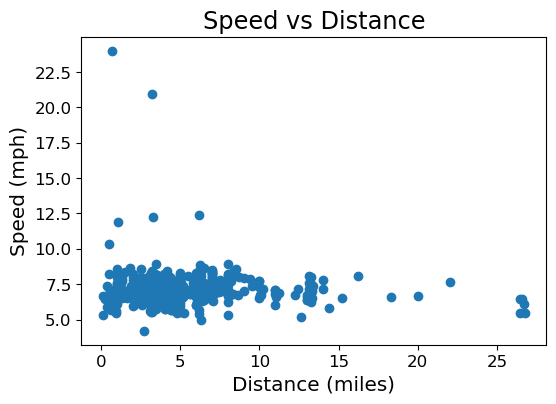

In [23]:
# Visual check

df_plot = df_running[df_running["speed_mph"] <= 100]

plt.figure(figsize=(6, 4))
plt.scatter(df_plot["Distance"], df_plot["speed_mph"])
plt.xlabel("Distance (miles)")
plt.ylabel("Speed (mph)")
plt.title("Speed vs Distance")

#### Exponentially Weighted Baselines

This allows for analysis against my most recent/last baseline.

In [24]:
# Make sure the data is sorted

df_running = df_running.sort_values("Date")

In [25]:
# Compute the baseline pace and deviation

df_running["baseline_pace"] = (
    df_running["avg_pace_sec"]
    .ewm(span=20, adjust=False)
    .mean()
)

df_running["pace_vs_baseline"] = (
    df_running["avg_pace_sec"] - df_running["baseline_pace"]
)

The interpretation for this baseline of 0:

- Negative (less than 0) → better than expected at that time
- Positive (greater than 0) → worse than expected

This is the core performance variable.

We'll then plot this variable over time, accounting for race days and training days:

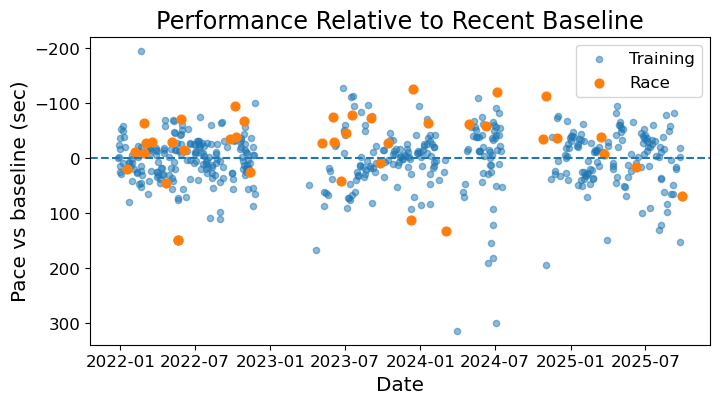

In [26]:
plt.figure(figsize=(8, 4))

# Training runs
train = df_running[df_running["is_race"] == 0]
plt.scatter(
    train["Date"],
    train["pace_vs_baseline"],
    alpha=0.5,
    s=20,
    label="Training"
)

# Races
race = df_running[df_running["is_race"] == 1]
plt.scatter(
    race["Date"],
    race["pace_vs_baseline"],
    s=40,
    label="Race"
)

plt.axhline(0, linestyle="--")
plt.xlabel("Date")
plt.ylabel("Pace vs baseline (sec)")
plt.title("Performance Relative to Recent Baseline")
plt.legend()
plt.gca().invert_yaxis()

Off the bat, we can see that most races are below 0. 3 are slightly on the line, and 10 are greater than 0. This suggests the baseline is reasonable, but races aren't automatically "good" - fatigue, conditions, or execution matter. This performance metric is sensitive but not brittle, and some noise is expected (weather, terrain, pacing).

Training performance is actually fairly static at a given time. Most of the peaks and troughs align with injury, but not all; so variation is contextual.

In terms of clustering, training vs races, races mostly cluster more, or follow a similar performance level. There's almost an arc with the race performance over time.

A big takeaway: races contain information training runs do not. Races appear to likely be more like “controlled experiments”, where I may have learned how to race better over time or hit a peak in 2024.

## Quantify Race vs Training Difference

Training runs are not always designed to maximize speed; therefore, variability in training performance reflects intent as much as fitness.

First, I'll compare the distributions of race vs training runs.

In [27]:
train = df_running[df_running["is_race"] == 0]["pace_vs_baseline"]
race = df_running[df_running["is_race"] == 1]["pace_vs_baseline"]

train.mean(), race.mean()

(1.4119165400866602, -18.357740382194702)

In [28]:
train.std(), race.std()

(50.94173019305393, 67.66036303242876)

To assess whether race performance differ extensively from training performance, I'll use an independent two-sample t-test. This compares the mean value of a chosen performance metric (in this case, Speed) between race runs and training runs while allowing for unequal sample sizes and variances.

Missing values are removed prior to testing, and the resulting test statistic and p-value indicate whether any observed difference in means is statistically significant.

This answers: “Are races statistically faster relative to baseline?”

In [29]:
from scipy.stats import ttest_ind

ttest_ind(race.dropna(), train.dropna(), equal_var=False)

TtestResult(statistic=-1.8077522279713876, pvalue=0.07771225892126399, df=42.58141160864637)

**p = 0.078** is not significant. The direction is correct, but it's probably too small of a sample size to really identify any significant trends.

So, I've compared the two run types *on average*. Next, I'll run a simple ordinary least squares (OLS) regression to examine whether race performance changes systematically over time. This analysis focuses exclusively on race runs and models performance relative to baseline as a function of race order.

By indexing races sequentially, this model tests for a directional trend (improvement or decline) across successive races rather than absolute differences between individual events. While overall explanatory power may be limited due to sample size and unobserved factors, the estimated slope provides insight into whether race performance evolves meaningfully over time.

In [30]:
# Add a trend just for races to quantify the arc I saw in the visual using OLS

race_df = df_running[df_running["is_race"] == 1].copy()
race_df["race_index"] = range(len(race_df))

import statsmodels.api as sm

X = sm.add_constant(race_df["race_index"])
y = race_df["pace_vs_baseline"]

sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       pace_vs_baseline   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.6528
Date:                Sat, 10 Jan 2026   Prob (F-statistic):              0.424
Time:                        21:00:23   Log-Likelihood:                -224.49
No. Observations:                  40   AIC:                             453.0
Df Residuals:                      38   BIC:                             456.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6906     21.095     -0.175      0.862     -46.396      39.014
race_index    -0.7522      0.931     -0.808      0.424      -2.637       1.132
==============================================================================
Omnibus:                        8.411   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                7.513
Skew:                           1.028   Prob(JB):                       0.0234
Kurtosis:                       3.527   Cond. No.                         44.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R² = 0.017, F = 0.65: the arc might visually be there if I ignore the data points that dip above 0, but it's not captured by a linear trend. 

But, I'll add heart rate into the mix to compare:

In [31]:
X = sm.add_constant(df_running[["Avg_HR", "is_race"]])
y = df_running["pace_vs_baseline"]

sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       pace_vs_baseline   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     8.436
Date:                Sat, 10 Jan 2026   Prob (F-statistic):           0.000247
Time:                        21:00:23   Log-Likelihood:                -2918.0
No. Observations:                 544   AIC:                             5842.
Df Residuals:                     541   BIC:                             5855.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         95.6229     27.903      3.427      0.001      40.812     150.433
Avg_HR        -0.6269      0.185     -3.388      0.001      -0.990      -0.263
is_race       -8.4912      9.141     -0.929      0.353     -26.447       9.465
==============================================================================
Omnibus:                      117.279   Durbin-Watson:                   1.662
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              472.039
Skew:                           0.921   Prob(JB):                    3.15e-103
Kurtosis:                       7.175   Cond. No.                     1.92e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.92e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R² = 0.017, F = 0.65: Low R² but significant F usually means that one predictor has a consistent but modest effect, or that there is lots of unexplained variance. The latter makes sense given this wasn't and couldn't be a perfectly controlled experiment. Comparing these results to the first OLS tells me that HR matters some, but context still dominates.

As seen in both OLS Regressions, low R² values are expected in endurance performance data due to unobserved variables (terrain, weather, fueling, injury, training intent). As a result, model coefficients and directionality are more informative here than overall explanatory power.

## Evaluate the Effect of Sleep within Races

Sleep in the way I've collected in (Yes or No to 7 or more hours of sleep) is:

- Binary (clean)
- Plausibly causal
- Likely to matter most when performance is maximized

Testing sleep across all runs would wash out the effect. But, testing sleep within races is as close as I can get to a controlled experiment.

Note: 1 = YES, I had 7 hours or more of sleep; 0 = NO, I did not have at least 7 hours of sleep

In [32]:
# Create a subset of races-only

race_df = df_running[df_running["is_race"] == 1].copy()

race_df["good_sleep"].value_counts()

good_sleep
1    20
0    20
Name: count, dtype: int64

It's an even distribution of YESs and NOs. First, I'll visualize how that amount of sleep worked against the baseline performance and pacing.

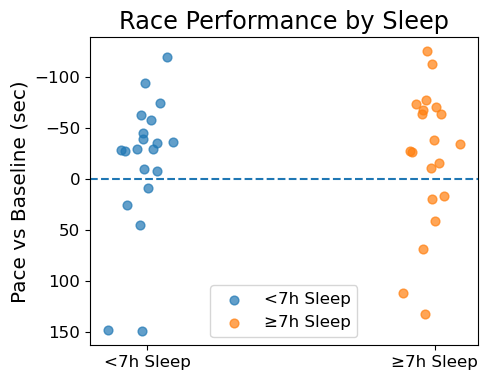

In [33]:
plt.figure(figsize=(5, 4))

# X positions with jitter
x_sleep_0 = np.zeros(len(race_df[race_df["good_sleep"] == 0]))
x_sleep_1 = np.ones(len(race_df[race_df["good_sleep"] == 1]))

plt.scatter(
    x_sleep_0 + np.random.normal(0, 0.05, len(x_sleep_0)),
    race_df[race_df["good_sleep"] == 0]["pace_vs_baseline"],
    alpha=0.7,
    s=40,
    label="<7h Sleep"
)

plt.scatter(
    x_sleep_1 + np.random.normal(0, 0.05, len(x_sleep_1)),
    race_df[race_df["good_sleep"] == 1]["pace_vs_baseline"],
    alpha=0.7,
    s=40,
    label="≥7h Sleep"
)

plt.axhline(0, linestyle="--")
plt.xticks([0, 1], ["<7h Sleep", "≥7h Sleep"])
plt.ylabel("Pace vs Baseline (sec)")
plt.title("Race Performance by Sleep")
plt.gca().invert_yaxis()
plt.legend()

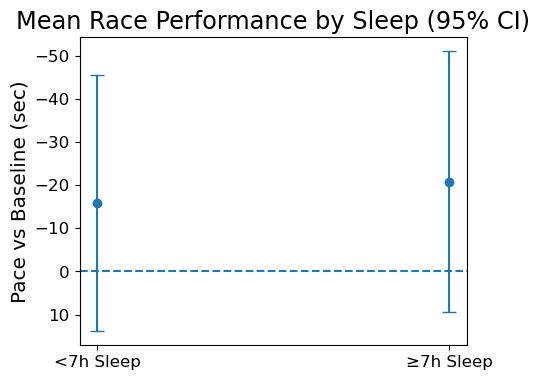

In [34]:
means = race_df.groupby("good_sleep")["pace_vs_baseline"].mean()
sems = race_df.groupby("good_sleep")["pace_vs_baseline"].sem()

plt.figure(figsize=(5, 4))
plt.errorbar(
    x=[0, 1],
    y=means,
    yerr=1.96 * sems,
    fmt="o",
    capsize=5
)

plt.axhline(0, linestyle="--")
plt.xticks([0, 1], ["<7h Sleep", "≥7h Sleep"])
plt.ylabel("Pace vs Baseline (sec)")
plt.title("Mean Race Performance by Sleep (95% CI)")
plt.gca().invert_yaxis()

Next, I'll run another OLS regression. This one examines whether sleep is associated with race performance after accounting for race-day effort. Performance is measured as pace relative to an individual baseline, while predictors include a binary indicator of adequate sleep (>7 hours) and average heart rate during the race.

By including both variables, the model assesses whether sleep has an independent relationship with performance rather than reflecting differences in effort alone. Results are interpreted descriptively since I couldn't manage more than 40 (recorded) races. Not a huge sample.

In [35]:
X = sm.add_constant(race_df[["good_sleep", "Avg_HR"]])
y = race_df["pace_vs_baseline"]

sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       pace_vs_baseline   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     1.690
Date:                Sat, 10 Jan 2026   Prob (F-statistic):              0.198
Time:                        21:00:23   Log-Likelihood:                -223.08
No. Observations:                  40   AIC:                             452.2
Df Residuals:                      37   BIC:                             457.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        351.2653    201.890      1.740      0.090     -57.803     760.333
good_sleep   -14.3139     21.646     -0.661      0.513     -58.173      29.545
Avg_HR        -2.1540      1.181     -1.824      0.076      -4.547       0.239
==============================================================================
Omnibus:                        3.023   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.221   Jarque-Bera (JB):                1.872
Skew:                           0.364   Prob(JB):                        0.392
Kurtosis:                       3.770   Cond. No.                     3.24e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This model explains a modest portion of the variation in race performance (R² = 0.084), which is expected given the small number of race observations and the many unmeasured factors that influence race outcomes. The overall model does not reach conventional levels of statistical significance (F = 1.69), indicating limited evidence that these predictors jointly explain performance variation.

The coefficient on good_sleep is negative but small and statistically insignificant, suggesting no clear relationship between getting more than seven hours of sleep and race performance for me. In contrast, average heart rate shows a larger negative association with performance relative to baseline, indicating that higher heart rates tend to coincide with faster-than-baseline performances - although this relationship falls just short of standard significance thresholds.

Overall, these results suggest that race-day physiological effort is more strongly related to performance than sleep quantity alone, though again, conclusions are limited by my small sample size.

In [36]:
from scipy.stats import mannwhitneyu

u, p = mannwhitneyu(
    race_df[race_df["good_sleep"] == 1]["pace_vs_baseline"].dropna(),
    race_df[race_df["good_sleep"] == 0]["pace_vs_baseline"].dropna(),
    alternative="less"
)

u, p

(189.0, 0.38819525277525657)

Across the full dataset, sleep metrics show weak and inconsistent relationships with performance. Restricting the analysis to race days suggests a possible relationship, but sample size is small and results should be interpreted cautiously.

## Visual Exploration

As I enjoy what can be gleaned just from a visualization, I will run a few more just focusing on seasonality and distance - together and separately.

In [37]:
df_running = df_running.set_index("Date")

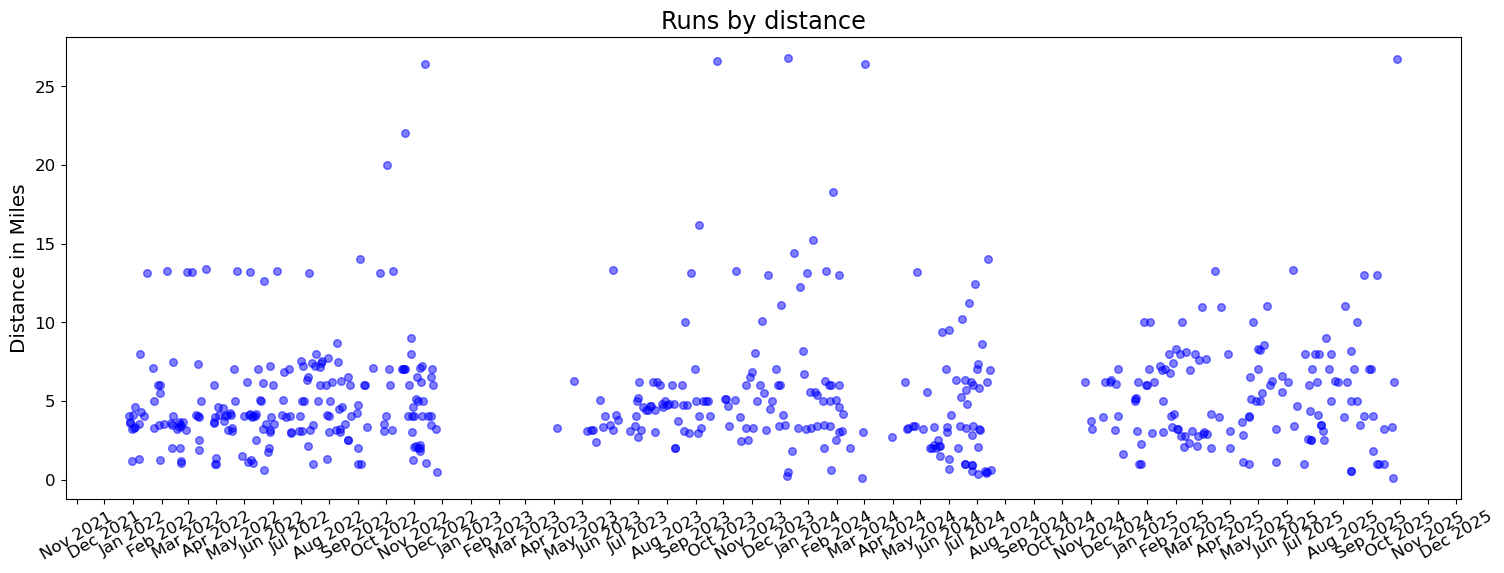

In [38]:
# Runs by distance mapped over time
fig, ax = plt.subplots(figsize=(18, 6))
plt.title('Runs by distance')
plt.ylabel('Distance in Miles')
plt.scatter(df_running.index, df_running["Distance"], label='Distance', c='blue', s=30, alpha=0.5)
ax.xaxis.set_major_locator(mdates.MonthLocator())
fmt = mdates.DateFormatter('%b %Y')
ax.xaxis.set_major_formatter(fmt)
plt.setp(ax.get_xticklabels(), rotation=30);

One can clearly see when I was injured. And nearly each time it was after a marathon! Neither the traditional marathon training method of ramping up the distance leading up to the race nor taking it easy beforehand worked. 

In [39]:
def season_from_month(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

df_running["season"] = df_running.index.month.map(season_from_month)

# Assign winter to the year of January/February
df_running["season_year"] = df_running.index.year
df_running.loc[df_running.index.month == 12, "season_year"] += 1

df_running["season_label"] = (
    df_running["season"] + " " + df_running["season_year"].astype(str)
)

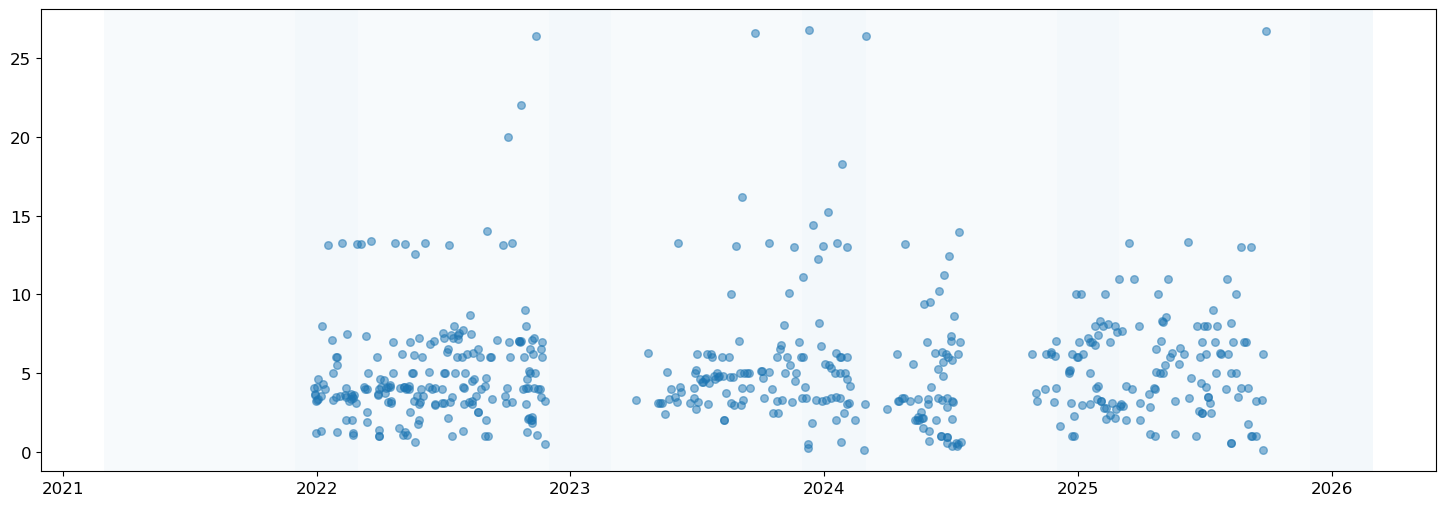

In [40]:
# Runs by distance mapped over time, by season
fig, ax = plt.subplots(figsize=(18, 6))

ax.scatter(
    df_running.index,
    df_running["Distance"],
    s=30,
    alpha=0.5
)

# Year ticks
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Optional: season shading
for year in df_running.index.year.unique():
    ax.axvspan(f'{year}-12-01', f'{year+1}-03-01', alpha=0.05)  # Winter
    ax.axvspan(f'{year}-03-01', f'{year}-06-01', alpha=0.03)  # Spring
    ax.axvspan(f'{year}-06-01', f'{year}-09-01', alpha=0.03)  # Summer
    ax.axvspan(f'{year}-09-01', f'{year}-12-01', alpha=0.03)  # Fall

Daily running distance remains relatively consistent over time, with intermittent spikes representing long runs or races rather than a gradual increase in overall mileage.

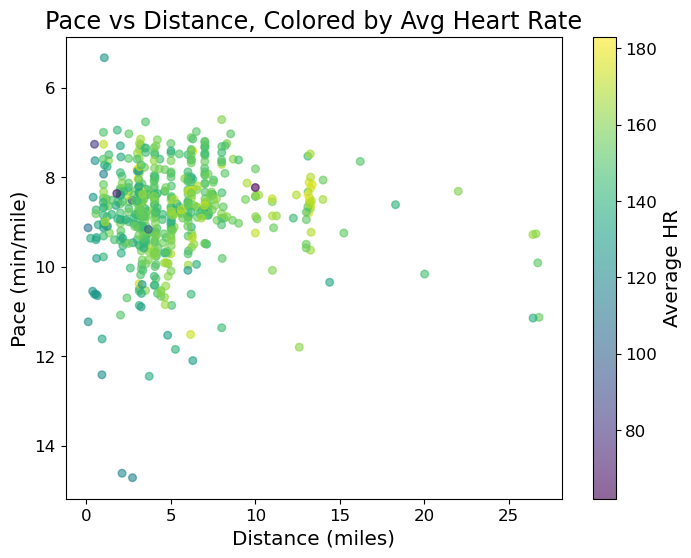

In [41]:
# Pace vs Distance, colored by HR

plt.figure(figsize=(8, 6))

sc = plt.scatter(
    df_running["Distance"],
    df_running["avg_pace_sec"] / 60,  # pace in min/mile
    c=df_running["Avg_HR"],
    cmap="viridis",
    alpha=0.6,
    s=30
)

plt.xlabel("Distance (miles)")
plt.ylabel("Pace (min/mile)")
plt.title("Pace vs Distance, Colored by Avg Heart Rate")

cbar = plt.colorbar(sc)
cbar.set_label("Average HR")

plt.gca().invert_yaxis()  # faster = higher on plot
plt.show()

Pace and distance show a clear endurance tradeoff: longer runs are slower and carried out at higher heart rates, while shorter runs display greater variability in both pace and effort.

In [42]:
df_running["is_race"] = df_running["Race"] == "Yes"

In [43]:
# Build weekly volume

df_running["week"] = df_running.index.to_period("W").start_time

weekly = (
    df_running
    .groupby("week")["Distance"]
    .sum()
)

In [44]:
race_weeks = (
    df_running[df_running["is_race"]]
    .groupby("week")["Distance"]
    .sum()
)

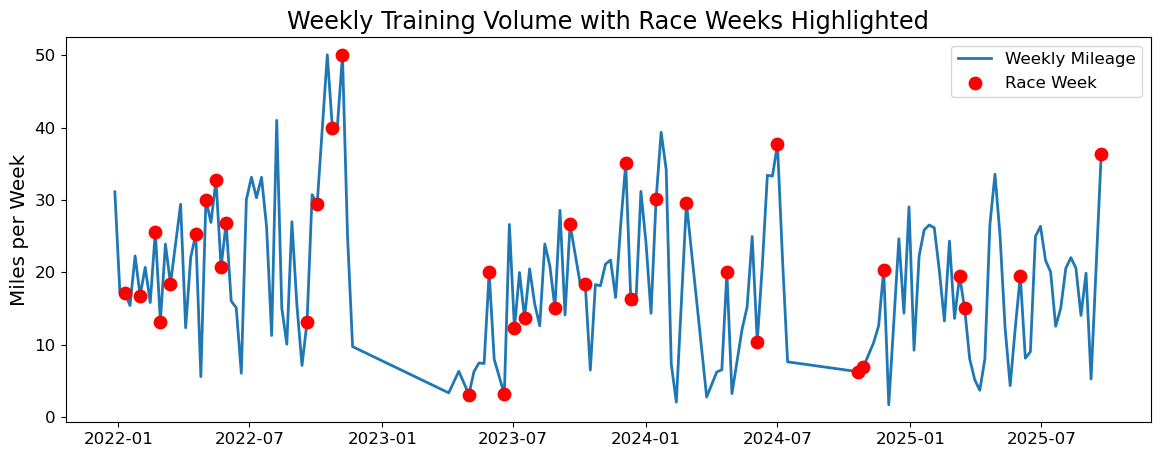

In [45]:
#Weekly training volume, highliting races to identify trends in race lead-up

plt.figure(figsize=(14, 5))

# Weekly mileage line
plt.plot(
    weekly.index,
    weekly.values,
    linewidth=2,
    label="Weekly Mileage"
)

# Race week markers
plt.scatter(
    race_weeks.index,
    weekly.loc[race_weeks.index],
    color="red",
    s=80,
    zorder=3,
    label="Race Week"
)

plt.ylabel("Miles per Week")
plt.title("Weekly Training Volume with Race Weeks Highlighted")
plt.legend()
plt.show()

Race performances are both faster and less variable than training runs, suggesting tighter physiological constraints and more consistent effort allocation under race conditions.

## What Could Still Be Tried?

Obviously, more runs would be nice for a variety of reasons. That won't be happening for, at least, several years, though. And never the longer distances. The scarcity of those limits any worthy evaluation of distance solely on my dataset.

All but 3 or 4 of these were road or treadmill runs, rather than trail runs, so that is already fairly consistent. But something that would impact any of the outdoor runs, races especially, would be weather. It would be interesting to source the temperature, humidity levels, precipitation (Y/N) for each.

## Final Takeaways

This analysis suggests that my race performance was more strongly associated with physiological effort (heart rate) and contextual factors than with training volume or sleep quantity alone. While sleep may matter at the margins, its effect is difficult to isolate with limited race observations. Overall, the results reinforce that endurance performance is multifactorial, noisy, and only partially observable, making careful design and cautious interpretation necessary. 

Thank you for reading!